In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import networkx as nx
import numpy.fft
import random
import bct
import math
import statistics
from source.phase_and_correlation_scramble import *
from source.utils.io_utils import readMRIFile, load_txt
from source.utils.matrix_utils import createCorrelationMatrix, findThreshold, binarize, randomizeCorrelationMatrix, null_covariance
from source.utils.plot_utils import plot_timeseries, plot_correlation_matrix, plot_flexibility_results
from source.utils.phase_utils import *

In [2]:
file_path = '/Users/nivaranavat/BrainConnectivity_ResearchProject/Data/SAL_01/roi'

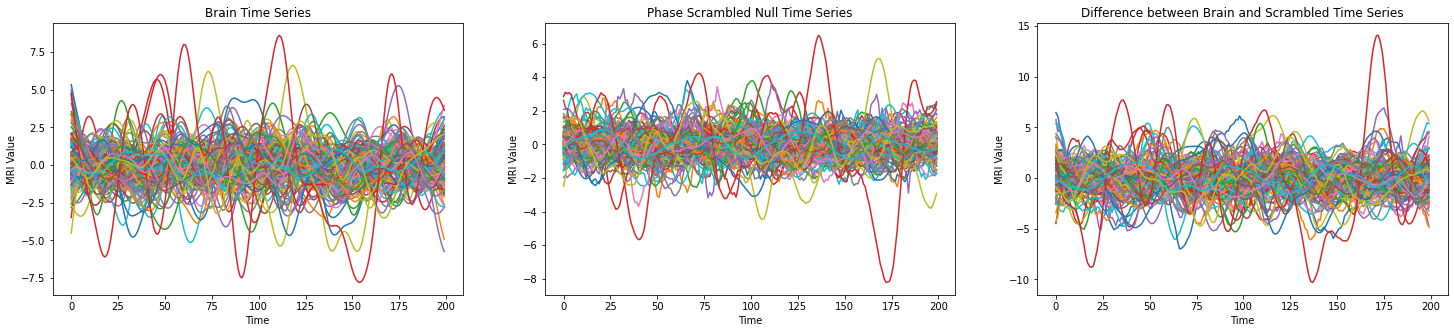

In [3]:

#the main function that will run the meat of our code

#read the data from our folder and generate a visualization plot
#using the observed brain data phase scramble the ROI's to create our null

#create the figure to add our plots
fig, ax = plt.subplots(nrows=1 , ncols=3, figsize=(25, 5))


#read the MRI data first and plot
x ,roi_timeseries = readMRIFile(file_path,200)
for i in roi_timeseries:
    ax[0].plot(x,i)
    ax[0].set_title("Brain Time Series")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("MRI Value")
    
#scramble the phases and plot that
null_timeseries = []
#doing the fourier transform on each 
for i in range(len(roi_timeseries)):
    series = phaseScramble1(roi_timeseries[i])
    null_timeseries.append(series)
    ax[1].plot(x,series.real)
    ax[1].set_title("Phase Scrambled Null Time Series")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("MRI Value")


#plot the difference between the two actual brain and the randomized brain
for i in range(len(roi_timeseries)):
    ax[2].plot(x,roi_timeseries[i] - null_timeseries[i].real)
    ax[2].set_title("Difference between Brain and Scrambled Time Series")
    ax[2].set_xlabel("Time")
    ax[2].set_ylabel("MRI Value")

    
#save the plots and display
plt.savefig("./results/PhaseScramblingPlots/TimeSeries Plots.png")
plt.show()


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/internals/managers.py:1464: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)  # type: ignore[arg-type]


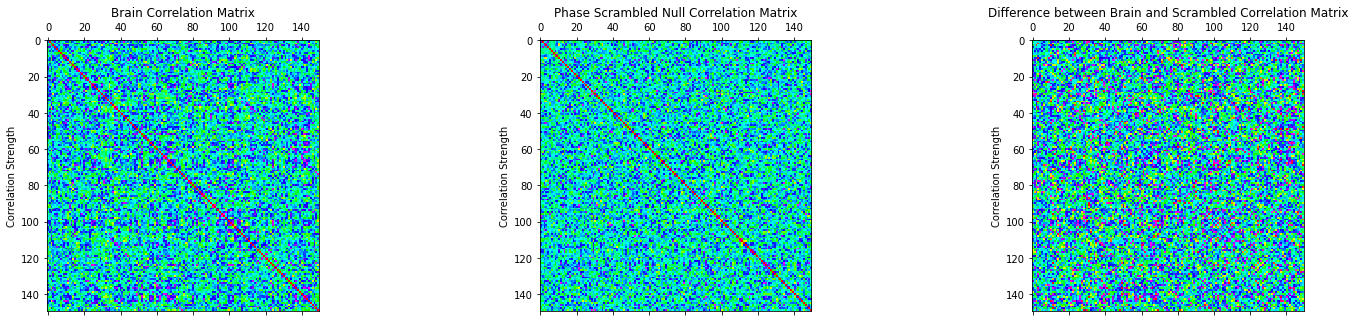

In [4]:
#find the correlation matrix and plot for the observed brain network and the phase scrambled null created

import matplotlib.colors

cmap = "hsv"
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)


#plot out the correlation matrices
fig, ax = plt.subplots(nrows=1 , ncols=3, figsize=(25, 5))

#create the correlation matrix for brain and null
brain_correlationMatrix = createCorrelationMatrix(roi_timeseries,"pearson")
brain_correlationMatrix = brain_correlationMatrix - np.identity(150)
null1_correlationMatrix = createCorrelationMatrix(null_timeseries,"pearson")
null1_correlationMatrix = null1_correlationMatrix - np.identity(150)

#plot the brain's correlation matrix
ax[0].matshow((brain_correlationMatrix-np.identity(150)),cmap = cmap, norm = norm)
ax[0].set_title("Brain Correlation Matrix")
ax[0].set_ylabel("Correlation Strength")

#plot the null's correlation matrix
ax[1].matshow((null1_correlationMatrix-np.identity(150)),cmap = cmap, norm = norm)
ax[1].set_title("Phase Scrambled Null Correlation Matrix")
ax[1].set_ylabel("Correlation Strength")
              
#plot the difference between brain and null correlation matrix             
ax[2].matshow((brain_correlationMatrix-np.identity(150))-(null1_correlationMatrix-np.identity(150)),cmap = cmap, norm = norm)
ax[2].set_title("Difference between Brain and Scrambled Correlation Matrix")
ax[2].set_ylabel("Correlation Strength")


#save the plots and display  
plt.savefig("./results/PhaseScramblingPlots/Correlation Matrix Plots.png")
plt.show()


Brain threshold:  0.2987099078999725
Null1 threshold:  0.2472715353145809


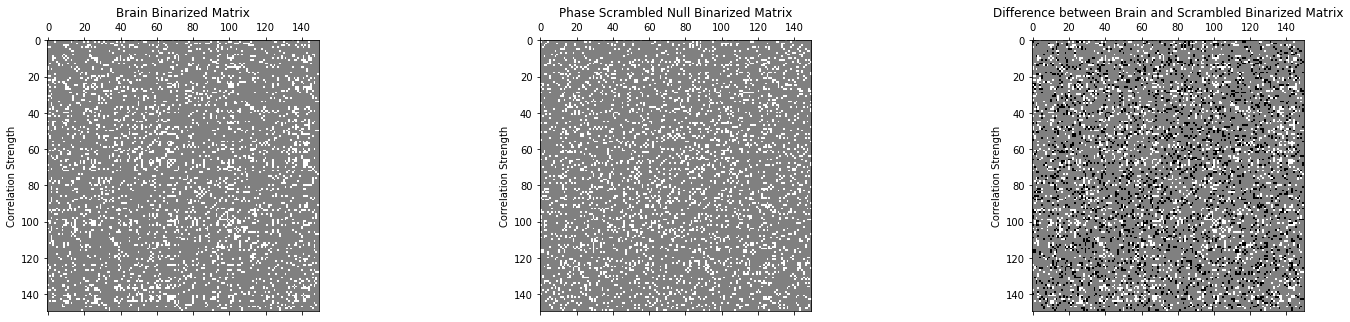

In [5]:
#binarize the networks using 15% density

cmap = "binary_r"
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)


#plot out the binarized matrices based on the correlation matrix and the threshold
fig, ax = plt.subplots(nrows=1 , ncols=3, figsize=(25, 5))

#binarize both brain and null correlation matrix
brain_threshold = findThreshold(brain_correlationMatrix,0.15)
null1_threshold = findThreshold(null1_correlationMatrix,0.15)
brain_binaryMatrix= binarize(brain_correlationMatrix,brain_threshold)
null1_binaryMatrix = binarize(null1_correlationMatrix,null1_threshold)

print("Brain threshold: ", brain_threshold)
print("Null1 threshold: ", null1_threshold)

#plot the brain's binarized matrix
ax[0].matshow((brain_binaryMatrix),cmap = cmap, norm = norm)
ax[0].set_title("Brain Binarized Matrix")
ax[0].set_ylabel("Correlation Strength")

#plot the null's graph
ax[1].matshow((null1_binaryMatrix),cmap = cmap, norm = norm)
ax[1].set_title("Phase Scrambled Null Binarized Matrix")
ax[1].set_ylabel("Correlation Strength")
              
           
#plot out the difference
ax[2].matshow((brain_binaryMatrix)-(null1_binaryMatrix),cmap = cmap, norm = norm)
ax[2].set_title("Difference between Brain and Scrambled Binarized Matrix")
ax[2].set_ylabel("Correlation Strength")
        
    
#save the plot and display it
plt.savefig("./results/PhaseScramblingPlots/Binarized Matrix Plots.png")
plt.show()


In [6]:

#next step is to check the ratios of coefficient and path length between our created null and the observed brain

#calculate our clustering coefficient, path length, and small worldness
#values should be >1 or ~1

small_worldness, normalized_ccoef, normalized_path_length = calculate_small_worldness(brain_binaryMatrix, null1_binaryMatrix)

print()
print("Ratios:")
print("Brain/Null1 path length: ", normalized_path_length)
print("Brain/Null1 clustering coefficient: " , normalized_ccoef)
print("Brain small worldness with null1: ", small_worldness)


Ratios:
Brain/Null1 path length:  1.0442213297634986
Brain/Null1 clustering coefficient:  1.1271844864523208
Brain small worldness with null1:  1.0794497816929407


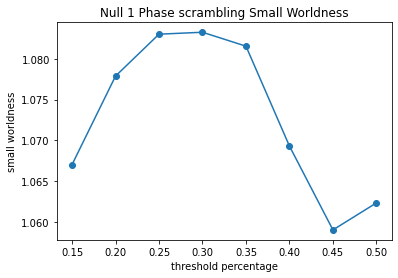

In [7]:
#try the range of 10% to 50% threshold density for binarizing the correlation matrix and plotting it


#first collect the data for the brain
x ,roi_timeseries = readMRIFile(file_path,200)
brain_correlationMatrix = createCorrelationMatrix(roi_timeseries,"pearson")

#scramble the phases
null_timeseries = []
#doing the fourier transform on each 
for i in range(len(roi_timeseries)):
    series = phaseScramble1(roi_timeseries[i])
    null_timeseries.append(series)

#correlation matrix
null1_correlationMatrix = createCorrelationMatrix(null_timeseries,"pearson")

small_worldness_values_null1 = []
percentage = 0.15

#the loop for the range
while percentage <= 0.50:
    
    
    # get the threshold
    brain_threshold = findThreshold(brain_correlationMatrix,percentage)
    null1_threshold = findThreshold(null1_correlationMatrix,percentage)
    
    #binarize
    brain_binaryMatrix = binarize(brain_correlationMatrix, brain_threshold)
    null1_binaryMatrix= binarize(null1_correlationMatrix,null1_threshold)
    
    
    #calculate small worldness
    small_worldness, normalized_ccoef, normalized_path_length = calculate_small_worldness(brain_binaryMatrix, null1_binaryMatrix)
    small_worldness_values_null1.append(small_worldness)
                                                                                          
    percentage += 0.05

    

plt.plot(np.arange(0.15,0.55,0.05),small_worldness_values_null1,marker ="o")
plt.xlabel("threshold percentage")
plt.ylabel("small worldness")
plt.title("Null 1 Phase scrambling Small Worldness")
plt.show()


    
    
    

With a percentage of:  0.15  Brain threshold:  0.2987099078999725
With a percentage of:  0.15  Null2 threshold:  4.603282203896397
With a percentage of:  0.2  Brain threshold:  0.2507188997645939
With a percentage of:  0.2  Null2 threshold:  3.422504374503041
With a percentage of:  0.25  Brain threshold:  0.20412672395269812
With a percentage of:  0.25  Null2 threshold:  2.594992256609016
With a percentage of:  0.3  Brain threshold:  0.1616937677722553
With a percentage of:  0.3  Null2 threshold:  2.0340151164741442
With a percentage of:  0.35  Brain threshold:  0.12189761956390219
With a percentage of:  0.35  Null2 threshold:  1.6015159911937014


/opt/anaconda3/lib/python3.7/statistics.py:355: RuntimeWarning: divide by zero encountered in double_scalars
  T, total, count = _sum(1/x for x in _fail_neg(data, errmsg))
/Users/nivaranavat/BrainConnectivity_ResearchProject/source/phase_and_correlation_scramble.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  ccoef_ratio = observed_ccoef/randomized_ccoef


With a percentage of:  0.39999999999999997  Brain threshold:  0.08477965951838143
With a percentage of:  0.39999999999999997  Null2 threshold:  1.2016137342272732
With a percentage of:  0.44999999999999996  Brain threshold:  0.048307571266671005
With a percentage of:  0.44999999999999996  Null2 threshold:  0.8304519937216516
With a percentage of:  0.49999999999999994  Brain threshold:  0.011410871061981902
With a percentage of:  0.49999999999999994  Null2 threshold:  0.42100720209863607
[inf, 0.6463563135396548, 0.6871262868590213, 0.7199274235594222, 0.7502736069787406, 0.7725472624036116, 0.7936796771616187, 0.8113078777277968]


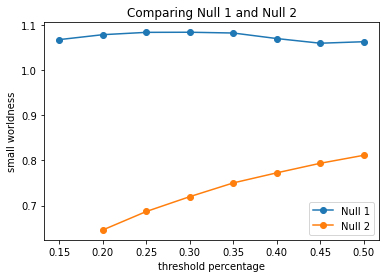

In [8]:
#getting the small worldness ratio for phase scrambled null and correlation matrix null and plotting it


small_worldness_values_null2 = []
percentage = 0.15

#randomize the correlation matrix
sd = getSDVofROITimeseries(roi_timeseries)
null2_correlationMatrix = null_covariance(brain_correlationMatrix,sd)

while percentage <= 0.50:
    
    # get the threshold
    brain_threshold = findThreshold(brain_correlationMatrix,percentage)
    null2_threshold = findThreshold(null2_correlationMatrix,percentage)
    
    #binarize
    brain_binaryMatrix = binarize(brain_correlationMatrix,brain_threshold)
    null2_binaryMatrix = binarize(null2_correlationMatrix,null2_threshold)
    
    print("With a percentage of: ", percentage, " Brain threshold: ", brain_threshold)
    print("With a percentage of: ",percentage , " Null2 threshold: ", null2_threshold)
    
    #calculate small worldness
    small_worldness, normalized_ccoef, normalized_path_length = calculate_small_worldness(brain_binaryMatrix, null2_binaryMatrix)
    small_worldness_values_null2.append(small_worldness)
    
    percentage += 0.05

print(small_worldness_values_null2)
plt.plot(np.arange(0.15,0.55,0.05),small_worldness_values_null1,marker ="o",label = "Null 1")
plt.plot(np.arange(0.15,0.55,0.05),small_worldness_values_null2,marker ="o",label = "Null 2")
plt.xlabel("threshold percentage")
plt.ylabel("small worldness")
plt.legend()
plt.title("Comparing Null 1 and Null 2")
plt.show()
    

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/internals/managers.py:1464: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)  # type: ignore[arg-type]


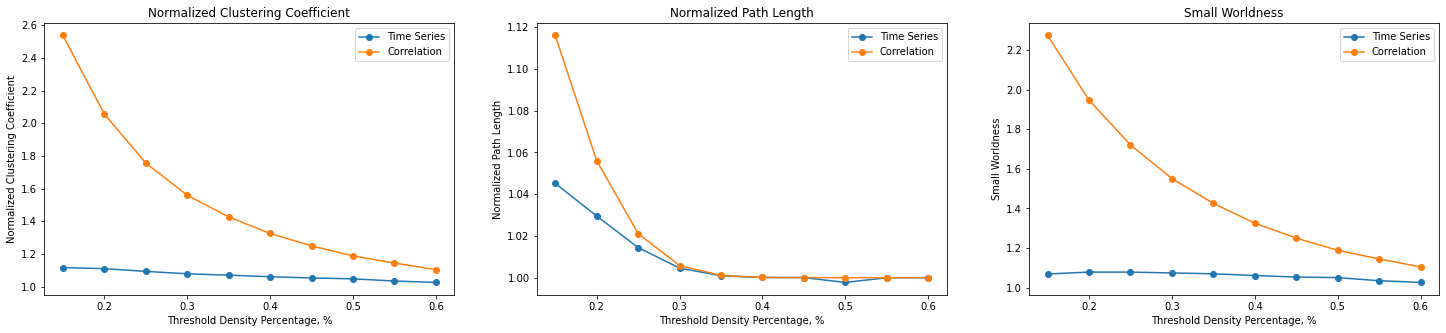

[2.53810819 2.05632096 1.75701167 1.55988908 1.42696537 1.32540197
 1.24963493 1.1880814  1.14432393 1.10436735]
[1.11600706 1.05608467 1.02112575 1.0058445  1.00109163 1.00010644
 1.00006363 0.99999522 1.0000234  1.0000051 ]
[2.2742734  1.94711748 1.72066151 1.55082529 1.42540937 1.3252609
 1.24955542 1.18808707 1.14429714 1.10436173]


In [9]:
#average it out for some iterations to normalize the randomness
#while also having a threshold density from 5% to 50%

iterations = 25

#first collect the data for the brain
x ,roi_timeseries = readMRIFile(file_path,200)
brain_correlationMatrix = createCorrelationMatrix(roi_timeseries,"pearson")


#range for the threshold percentages
start = 0.15
end = 0.60
delta = 0.05
threshold_range = int((end-start)//delta)+2

#store the small worldness values
small_worldness_values_null1 = np.zeros((iterations,threshold_range))
small_worldness_values_null2 = np.zeros((iterations,threshold_range))

#store clustering coefficient
clustering_coef_values_null1 = np.zeros((iterations,threshold_range))
clustering_coef_values_null2 = np.zeros((iterations,threshold_range))

#store path length values
path_length_values_null1 = np.zeros((iterations,threshold_range))
path_length_values_null2 = np.zeros((iterations,threshold_range))

for iter in range(iterations):
    
    #scramble the phases for null1
    null1_timeseries = []
    #doing the fourier transform on each 
    for i in range(len(roi_timeseries)):
        series = phaseScramble1(roi_timeseries[i])
        null1_timeseries.append(series)

    #correlation matrix
    null1_correlationMatrix = createCorrelationMatrix(null1_timeseries,"pearson")

    #randomize the correlation matrix for null 2
    sd = getSDVofROITimeseries(roi_timeseries)
    null2_correlationMatrix = randomizeCorrelationMatrix(brain_correlationMatrix,sd)
    
    percentage = start
    p_iter = 0

    #the loop for the range of threshold
    while percentage <= end:

        
         # get the threshold
        brain_threshold = findThreshold(brain_correlationMatrix,percentage)
        null1_threshold = findThreshold(null1_correlationMatrix,percentage)
        null2_threshold = findThreshold(null2_correlationMatrix,percentage)
        
        #binarize
        brain_binaryMatrix = binarize(brain_correlationMatrix,brain_threshold)
        null1_binaryMatrix = binarize(null1_correlationMatrix,null1_threshold)
        null2_binaryMatrix = binarize(null2_correlationMatrix,null2_threshold)

        
        
        #calculate clustering coefficient
        small_worldness_null1, normalized_ccoef_null1, normalized_path_length_null1 = calculate_small_worldness(brain_binaryMatrix, null1_binaryMatrix)
        small_worldness_null2, normalized_ccoef_null2, normalized_path_length_null2 = calculate_small_worldness(brain_binaryMatrix, null2_binaryMatrix)
        
        clustering_coef_values_null1[iter][p_iter] = normalized_ccoef_null1
        clustering_coef_values_null2[iter][p_iter] = normalized_ccoef_null2
    
        
        path_length_values_null1[iter][p_iter] = normalized_path_length_null1
        path_length_values_null2[iter][p_iter] = normalized_path_length_null2
        
        small_worldness_values_null1[iter][p_iter] = small_worldness_null1
        small_worldness_values_null2[iter][p_iter] = small_worldness_null2

        
        percentage += delta
        p_iter += 1

    
#store the small worldness values
small_worldness_values_null1_avg = np.mean(small_worldness_values_null1,axis=0)
small_worldness_values_null2_avg = np.mean(small_worldness_values_null2,axis=0)

#store clustering coefficient
clustering_coef_values_null1_avg = np.mean(clustering_coef_values_null1,axis=0)
clustering_coef_values_null2_avg = np.mean(clustering_coef_values_null2,axis=0)

#store path length values
path_length_values_null1_avg = np.mean(path_length_values_null1,axis=0)
path_length_values_null2_avg = np.mean(path_length_values_null2,axis=0)



#plot the averages that was found so far
fig,ax = plt.subplots(1,3,figsize = (25,5))

ax[0].plot(np.arange(start,end+delta,delta),clustering_coef_values_null1_avg,marker='o',label = "Time Series")
ax[0].plot(np.arange(start,end+delta,delta),clustering_coef_values_null2_avg,marker='o',label = "Correlation")
ax[0].set_title("Normalized Clustering Coefficient")
ax[0].set_ylabel("Normalized Clustering Coefficient")
ax[0].set_xlabel("Threshold Density Percentage, %")
ax[0].legend()

ax[1].plot(np.arange(start,end+delta,delta),path_length_values_null1_avg,marker='o',label = "Time Series")
ax[1].plot(np.arange(start,end+delta,delta),path_length_values_null2_avg,marker='o',label = "Correlation")
ax[1].set_title("Normalized Path Length")
ax[1].set_ylabel("Normalized Path Length")
ax[1].set_xlabel("Threshold Density Percentage, %")
ax[1].legend()


ax[2].plot(np.arange(start,end+delta,delta),small_worldness_values_null1_avg,marker='o',label = "Time Series")
ax[2].plot(np.arange(start,end+delta,delta),small_worldness_values_null2_avg,marker='o',label = "Correlation")
ax[2].set_title("Small Worldness")
ax[2].set_ylabel("Small Worldness")
ax[2].set_xlabel("Threshold Density Percentage, %")
ax[2].legend()     

#save the figure
plt.savefig("./results/PhaseScramblingPlots/Average Small Worldness Plots.png")
plt.show()

print(clustering_coef_values_null2_avg)
print(path_length_values_null2_avg)
print(small_worldness_values_null2_avg)

/opt/anaconda3/lib/python3.7/statistics.py:355: RuntimeWarning: divide by zero encountered in double_scalars
  T, total, count = _sum(1/x for x in _fail_neg(data, errmsg))
/Users/nivaranavat/BrainConnectivity_ResearchProject/source/phase_and_correlation_scramble.py:97: RuntimeWarning: divide by zero encountered in double_scalars
  ccoef_ratio = observed_ccoef/randomized_ccoef


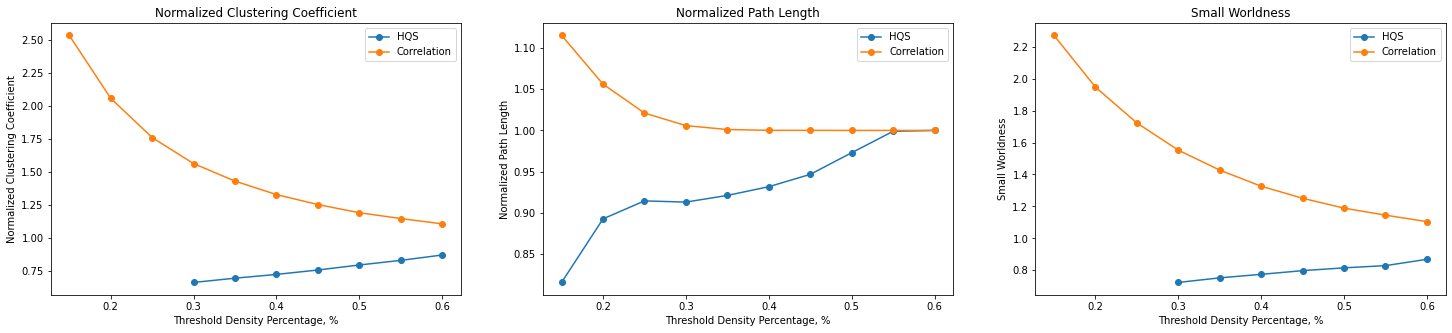

In [10]:
#average it out for some iterations to normalize the randomness
#while also having a threshold density from 5% to 50%

iterations = 25

#first collect the data for the brain
x ,roi_timeseries = readMRIFile(file_path,200)
brain_correlationMatrix = createCorrelationMatrix(roi_timeseries,"pearson")


#range for the threshold percentages
start = 0.15
end = 0.60
delta = 0.05
threshold_range = int((end-start)//delta)+2

#store the small worldness values
small_worldness_values_null2_1 = np.zeros((iterations,threshold_range))
small_worldness_values_null2_2 = np.zeros((iterations,threshold_range))

#store clustering coefficient
clustering_coef_values_null2_1 = np.zeros((iterations,threshold_range))
clustering_coef_values_null2_2 = np.zeros((iterations,threshold_range))

#store path length values
path_length_values_null2_1 = np.zeros((iterations,threshold_range))
path_length_values_null2_2 = np.zeros((iterations,threshold_range))

for iter in range(iterations):
    

    #randomize the correlation matrix for null 2
    sd = getSDVofROITimeseries(roi_timeseries)
    null2_correlationMatrix1 = null_covariance(brain_correlationMatrix,sd)
    null2_correlationMatrix2 = randomizeCorrelationMatrix(brain_correlationMatrix,sd)
    
    percentage = start
    p_iter = 0

    #the loop for the range of threshold
    while percentage <= end:

        
         # get the threshold
        brain_threshold = findThreshold(brain_correlationMatrix,percentage)
        null2_threshold1 = findThreshold(null2_correlationMatrix1,percentage)
        null2_threshold2 = findThreshold(null2_correlationMatrix2,percentage)
        
        #binarize
        brain_binaryMatrix = binarize(brain_correlationMatrix,brain_threshold)
        null2_binaryMatrix1 = binarize(null2_correlationMatrix1,null2_threshold1)
        null2_binaryMatrix2 = binarize(null2_correlationMatrix2,null2_threshold2)

        
        
        #calculate clustering coefficient
        small_worldness_null2_1, normalized_ccoef_null2_1, normalized_path_length_null2_1 = calculate_small_worldness(brain_binaryMatrix, null2_binaryMatrix1)
        small_worldness_null2_2, normalized_ccoef_null2_2, normalized_path_length_null2_2 = calculate_small_worldness(brain_binaryMatrix, null2_binaryMatrix2)
        
        clustering_coef_values_null2_1[iter][p_iter] = normalized_ccoef_null2_1
        clustering_coef_values_null2_2[iter][p_iter] = normalized_ccoef_null2_2
    
        
        path_length_values_null2_1[iter][p_iter] = normalized_path_length_null2_1
        path_length_values_null2_2[iter][p_iter] = normalized_path_length_null2_2
        
        small_worldness_values_null2_1[iter][p_iter] = small_worldness_null2_1
        small_worldness_values_null2_2[iter][p_iter] = small_worldness_null2_2

        
        percentage += delta
        p_iter += 1

    
#store the small worldness values
small_worldness_values_null2_1_avg = np.mean(small_worldness_values_null2_1,axis=0)
small_worldness_values_null2_2_avg = np.mean(small_worldness_values_null2_2,axis=0)

#store clustering coefficient
clustering_coef_values_null2_1_avg = np.mean(clustering_coef_values_null2_1,axis=0)
clustering_coef_values_null2_2_avg = np.mean(clustering_coef_values_null2_2,axis=0)

#store path length values
path_length_values_null2_1_avg = np.mean(path_length_values_null2_1,axis=0)
path_length_values_null2_2_avg = np.mean(path_length_values_null2_2,axis=0)



#plot the averages that was found so far
fig,ax = plt.subplots(1,3,figsize = (25,5))

ax[0].plot(np.arange(start,end+delta,delta),clustering_coef_values_null2_1_avg,marker='o',label = "HQS")
ax[0].plot(np.arange(start,end+delta,delta),clustering_coef_values_null2_2_avg,marker='o',label = "Correlation")
ax[0].set_title("Normalized Clustering Coefficient")
ax[0].set_ylabel("Normalized Clustering Coefficient")
ax[0].set_xlabel("Threshold Density Percentage, %")
ax[0].legend()

ax[1].plot(np.arange(start,end+delta,delta),path_length_values_null2_1_avg,marker='o',label = "HQS")
ax[1].plot(np.arange(start,end+delta,delta),path_length_values_null2_2_avg,marker='o',label = "Correlation")
ax[1].set_title("Normalized Path Length")
ax[1].set_ylabel("Normalized Path Length")
ax[1].set_xlabel("Threshold Density Percentage, %")
ax[1].legend()


ax[2].plot(np.arange(start,end+delta,delta),small_worldness_values_null2_1_avg,marker='o',label = "HQS")
ax[2].plot(np.arange(start,end+delta,delta),small_worldness_values_null2_2_avg,marker='o',label = "Correlation")
ax[2].set_title("Small Worldness")
ax[2].set_ylabel("Small Worldness")
ax[2].set_xlabel("Threshold Density Percentage, %")
ax[2].legend()     

#save the figure
plt.savefig("./results/PhaseScramblingPlots/Average Small Worldness Plots.png")
plt.show()

# print(clustering_coef_values_null2_avg)
# print(path_length_values_null2_avg)
# print(small_worldness_values_null2_avg)